# Cervical Cancer prediction

#### Source - https://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29#



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from category_encoders import OneHotEncoder, OrdinalEncoder

## 1. Data wrangling

In [6]:
def wrangle(filepath):
    df = pd.read_csv(filepath, na_values='?')

    # drop some cols because they are redundant target variables
    drop_cols = ['Hinselmann', 'Schiller', 'Citology']
    df.drop(columns=drop_cols, inplace=True)
    
    # drop some cols because more than 60% of the observations are null values
    drop_cols2 = ['STDs: Time since first diagnosis',
                  'STDs: Time since last diagnosis']
    df.drop(columns=drop_cols2, inplace=True)

    return df

In [7]:
file = 'risk_factors_cervical_cancer.csv'
df = wrangle(file)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

In [9]:
df.head()


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0,1,0,1,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [10]:
df['Biopsy'].value_counts()

0    803
1     55
Name: Biopsy, dtype: int64

## 2. Split the data

In [11]:
target = 'Biopsy'
X = df.drop(columns=target)
y = df[target]

In [12]:
# Split the data into Test/Train/Validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## 3. Establish the Baseline

In [13]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.9324817518248175


## 4. Build models

In [14]:
# Random forest
model = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        RandomForestClassifier(n_estimators=25,
                               n_jobs=-1,
                               random_state=42)
        )

model.fit(X_train, y_train);

## 5. Check the metrics

In [15]:
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9981751824817519
Validation Accuracy Score: 0.9420289855072463


## 6. Tune the model

In [16]:
param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(5,40,5),
    'randomforestclassifier__n_estimators': range(25, 125, 25)
}

model_rs = RandomizedSearchCV(
    model, 
    param_distributions=param_grid,
    n_iter=3,
    cv=None,
    n_jobs=-1,
    verbose=1
)

model_rs.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/venkateshvadlamani/.local/share/virtualenvs/cervical-cancer-yCs9CgAK/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=[],
                                                             mapping=[])),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_estimators=25,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 40, 5),
                                        'randomforestclassifier__n_estimators': range(25, 125, 25),
                                        'simpleimputer__strategy': ['mean',
                                                                    'med

In [17]:
print(model_rs.best_score_)

model_rs.fit(X_test, y_test)
test_acc = model_rs.best_score_
print('Testing Accuracy Score:', test_acc)

0.9270225187656379
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/venkateshvadlamani/.local/share/virtualenvs/cervical-cancer-yCs9CgAK/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Testing Accuracy Score: 0.9361344537815126


## 7. Communicate Results

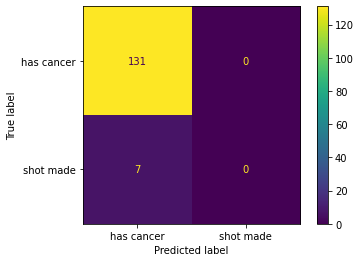

In [18]:
# plot confusion matrix
plot_confusion_matrix(
    model_rs,
    X_val, # BE SURE TO USE VALIDATION DATA
    y_val,
    values_format='.0f',
    display_labels=['has cancer', 'shot made']
);

In [19]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = model.named_steps['ordinalencoder'].get_feature_names()

feat_imp = pd.Series(importances, index=features).sort_values()

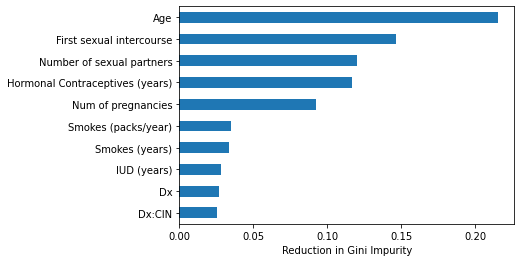

In [20]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');